In [2]:

# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, KFold
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")


Using TensorFlow backend.


https://towardsdatascience.com/machine-learning-model-for-predicting-click-through-in-hotel-online-ranking-d55fc18c8516
https://www.kaggle.com/konchada/logistic-vs-random-forest-model-for-ad-click
https://becominghuman.ai/predicting-click-probabilities-on-a-leading-advertising-platform-7582633e6e78
https://towardsdatascience.com/mobile-ads-click-through-rate-ctr-prediction-44fdac40c6ff

In [70]:
item_data=pd.read_csv("item_data.csv")
train = pd.read_csv("train.csv")
view_log = pd.read_csv("view_log.csv")
test=pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [159]:
test=pd.read_csv("test.csv")

In [236]:
item_data.shape,


((132761, 6),)

In [237]:
train.shape,


((237609, 7),)

In [238]:
view_log.shape


(3118622, 5)

In [160]:
test.shape,


((90675, 6),)

In [12]:
sample_submission.shape

(90675, 2)

In [13]:
item_data.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [3]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [134]:
train = train.drop(['ad_count','app_code1','click_sum','app_code2'], axis=1)

In [15]:
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [16]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1


In [17]:
sample_submission.head()

,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0
1,caac14a5bf2ba283db7708bb34855760,0
2,13f10ba306a19ce7bec2f3cae507b698,0
3,39c4b4dc0e9701b55a0a4f072008fb3f,0
4,bf5a572cca75f5fc67f4b14e58b11d70,0


In [4]:
log_item_merge =pd.merge(view_log,item_data,on='item_id',how ='left' )

In [5]:
log_item_merge.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
0,2018-10-15 08:58:00,android,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0
1,2018-10-15 08:58:00,android,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0
2,2018-10-15 08:58:00,android,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0
3,2018-10-15 08:58:00,android,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0
4,2018-10-15 08:58:00,android,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0


In [71]:
#High no of ad's(app_code) count given to app priorities by (High, Medium, low)

#app_ad_cnt=train.groupby(['app_code'])['is_click'].count()#.nlargest().reset_index()
#app_ad_cnt=train.groupby('app_code').agg({"is_click": "count"}).reset_index(drop=False)
#app_ad_cnt=train.groupby(['app_code'], as_index=True)[['is_click']].count()
#app_ad_cnt= train.loc[:,['app_code','is_click']]
#app_ad_cnt['ad_count']=train.groupby(['app_code'])['is_click'].count()

app_ad_cnt=train.groupby('app_code').agg({"is_click": "count"})
app_ad_cnt.rename(columns={"is_click":"ad_count"},inplace=True)
app_ad_cnt['app_code']=app_ad_cnt.index

In [72]:
app_ad_cnt.rename(columns={"app_code":"app_code1"},inplace=True)

In [76]:
min(app_ad_cnt['ad_count']),max(app_ad_cnt['ad_count']),np.mean(app_ad_cnt['ad_count'])

(1, 33788, 484.91632653061225)

In [73]:
app_ad_cnt['ad_pri'] = np.where( (app_ad_cnt['ad_count'] > 2000), 1, 0)

In [9]:
app_ad_cnt['ad_pri'].value_counts()

0    464
1     26
Name: ad_pri, dtype: int64

In [10]:
app_ad_cnt.head()

,ad_count,app_code1,ad_pri
app_code,,,
0,73,0,0
1,35,1,0
2,134,2,0
3,8860,3,1
4,2,4,0


In [74]:
app_ad_cli=train.groupby('app_code').agg({"is_click": "sum"})
app_ad_cli.rename(columns={"is_click":"click_sum"},inplace=True)
app_ad_cli['app_code']=app_ad_cli.index

In [75]:
app_ad_cli.rename(columns={"app_code":"app_code2"},inplace=True)

In [76]:
app_ad_cli['ad_click'] = np.where( (app_ad_cli['click_sum'] > 100), 1, 0)

In [15]:
app_ad_cli.head()

,click_sum,app_code2,ad_click
app_code,,,
0,6,0,0
1,3,1,0
2,9,2,0
3,305,3,1
4,0,4,0


In [104]:
train.groupby(['app_code'])['is_click'].count().nlargest(5).reset_index()

,app_code,is_click
0,207,33788
1,386,30706
2,190,17441
3,127,10851
4,371,9343


In [93]:
train1=train

In [94]:
train1=test

In [79]:
train =pd.merge(train1,app_ad_cnt,left_on="app_code", right_on="app_code1",how ='left' )


In [80]:
train =pd.merge(train,app_ad_cli,left_on="app_code", right_on="app_code2",how ='left' )


In [81]:
train = train.drop(['app_code1','app_code2'], axis=1)

In [352]:
test.head()

,impression_id,user_id,app_code,os_version,is_4G,ad_pri,ad_click,impression_time_Timestamp,Month,Day,Hour,Weekday,is_click,intermediate,latest,old
0,a9e7126a585a69a32bc7414e9d0c0ada,44754,127,latest,1,1,1,2018-12-13 07:44:00,12,13,7,3,0,0,1,0
1,caac14a5bf2ba283db7708bb34855760,29656,44,latest,0,1,0,2018-12-13 07:45:00,12,13,7,3,0,0,1,0
2,13f10ba306a19ce7bec2f3cae507b698,25234,296,latest,1,1,1,2018-12-13 07:46:00,12,13,7,3,0,0,1,0
3,39c4b4dc0e9701b55a0a4f072008fb3f,22988,207,latest,1,1,1,2018-12-13 07:47:00,12,13,7,3,0,0,1,0
4,bf5a572cca75f5fc67f4b14e58b11d70,35431,242,latest,1,1,1,2018-12-13 07:48:00,12,13,7,3,0,0,1,0


In [161]:
test =pd.merge(test,app_ad_cnt,left_on="app_code", right_on="app_code1",how ='left' )


In [162]:
test =pd.merge(test,app_ad_cli,left_on="app_code", right_on="app_code2",how ='left' )

In [163]:
test = test.drop(['app_code1','app_code2'], axis=1)

In [164]:
test.shape,

((90675, 10),)

In [135]:
print(pd.crosstab(train['ad_pri'],train['is_click']))

is_click       0     1
ad_pri                
0          41400  2660
1         185347  8202


In [136]:
print(pd.crosstab(train['ad_click'],train['is_click']))

is_click       0     1
ad_click              
0          49602  2580
1         177145  8282


In [67]:
view_log['device_type'].value_counts()

android    3117737
iphone         861
web             24
Name: device_type, dtype: int64

In [68]:
train['os_version'].value_counts()

latest          129216
intermediate     55543
old              52850
Name: os_version, dtype: int64

In [110]:
train['is_click'].value_counts()

0    226747
1     10862
Name: is_click, dtype: int64

In [70]:
print(pd.crosstab(train['is_4G'],train['is_click']))

is_click       0     1
is_4G                 
0         144738  7020
1          82009  3842


In [125]:
userclick1=train.groupby('user_id')['is_click'].sum()#>'0'

In [161]:
train.groupby('user_id')['is_click'].sum().nlargest(5)

user_id
784      15
54611    15
84559    15
8121     14
79033    13
Name: is_click, dtype: int64

In [172]:
train.groupby('user_id')['is_click'].count().nlargest(5)

user_id
71457    73
29947    70
59007    70
52082    67
68540    64
Name: is_click, dtype: int64

In [56]:
userclick1=train.groupby('user_id').agg({"is_click": "count"})

In [57]:
userclick1.rename(columns={"is_click":"is_click_count"},inplace=True)

In [63]:
userclick1['user_id']=userclick1.index

In [64]:
userclick1[userclick1['is_click_count']==73]

,is_click_count,user_id
user_id,,
71457,73,71457


In [193]:
userclick2.rename(columns={"is_click":"is_click_sum"},inplace=True)

In [194]:
userclick2[userclick2['is_click_sum']>=10]

,is_click_sum
user_id,
784,15
3364,10
8121,14
35126,11
37747,10
52485,11
52737,10
54611,15
55183,12


In [192]:
userclick1[userclick1['is_click_count']>=70]

,is_click_count
user_id,
29947,70
59007,70
71457,73


In [189]:
train.query('user_id==68540 and is_click ==1').count()

impression_id                9
user_id                      9
app_code                     9
os_version                   9
is_4G                        9
is_click                     9
impression_time_Timestamp    9
Month                        9
Day                          9
Hour                         9
Weekday                      9
dtype: int64

In [72]:
print(pd.crosstab(train['app_code'],train['is_click'])).size().nlargest(5)

is_click     0    1
app_code           
0           67    6
1           32    3
2          125    9
3         8555  305
4            2    0
5         5006  396
6            1    0
7          726   45
8           27    5
9          675   46
12           2    0
13           1    0
14          80   17
15           2    0
16         103   13
17          59    2
19          22    2
20          26    2
21           1    0
22          10    2
23           6    0
24          28    0
25           8    0
26           1    0
27          17    1
28           1    1
29          44    8
30           5    0
31         106    3
32        5718  266
...        ...  ...
489         68    2
491        421   16
492         79    6
493         17    5
495        167    6
496         90    1
497          1    0
498         19    0
499         62    3
500         20    1
502          1    0
503         73    5
504        279   47
505        145    4
506          9    0
507        399   14
508       1686  132


AttributeError: 'NoneType' object has no attribute 'size'

In [73]:
print(pd.crosstab(train['os_version'],train['is_click']))


is_click           0     1
os_version                
intermediate   52668  2875
latest        123834  5382
old            50245  2605


In [26]:
#Analysing user base train recored
view_log.query('user_id==87862')

,server_time,device_type,session_id,user_id,item_id
221309,2018-10-19 18:11:00,android,190710,87862,43886


In [27]:
item_data.query('item_id==43886')

,item_id,item_price,category_1,category_2,category_3,product_type
115593,43886,2350,11,35,20,5622


In [28]:
train.query('user_id ==87862')

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
616,621bf66ddb7c962aa0d22ac97d69b793,2018-11-15 00:19:00,87862,422,old,0,0
5936,ab394288aed46588bdc90bf4b541ec0d,2018-11-16 17:29:00,87862,422,old,0,0


In [30]:

view_log.query('user_id==63410')

,server_time,device_type,session_id,user_id,item_id
284024,2018-10-21 06:13:00,android,356854,63410,43209
284028,2018-10-21 06:13:00,android,356854,63410,66370
309046,2018-10-21 17:01:00,android,345289,63410,43209
339224,2018-10-22 09:54:00,android,406658,63410,43209
449354,2018-10-24 11:14:00,android,15568,63410,71877
486317,2018-10-25 05:00:00,android,343558,63410,43209
486325,2018-10-25 05:03:00,android,343558,63410,43209
2115995,2018-11-24 05:29:00,android,983607,63410,97274
3028698,2018-12-10 19:48:00,android,135003,63410,109074
3028895,2018-12-10 19:51:00,android,135003,63410,58018


In [39]:
item_data.query('item_id==43209 or item_id==66370 or item_id ==71877 or item_id ==97274 or item_id ==109074 or item_id ==58018 or item_id ==22064')

,item_id,item_price,category_1,category_2,category_3,product_type
52,109074,6330,10,63,295,9337
10689,71877,3961,10,63,295,2270
50221,22064,1024,11,76,67,8411
55749,58018,1888,13,52,163,2734
60403,43209,3421,4,74,292,577
96448,97274,2630,10,43,223,3055
117273,66370,14166,4,74,292,3399


In [47]:
item_data.query('product_type == 386')

,item_id,item_price,category_1,category_2,category_3,product_type
88047,25430,300,15,0,214,386


In [216]:
train.query('app_code ==386').head(10)

,impression_id,user_id,app_code,os_version,is_4G,is_click,ad_pri,ad_click,impression_time_Timestamp,Month,Day,Hour,Weekday,intermediate,latest,old
8,fc490ca45c00b1249bbe3554a4fdf6fb,83318,386,old,0,0,1,1,2018-11-15 00:05:00,11,15,0,3,0,0,1
47,70c639df5e30bdee440e4cdf599fec2b,14496,386,latest,0,0,1,1,2018-11-15 00:34:00,11,15,0,3,0,1,0
85,5f0f5e5f33945135b874349cfbed4fb9,75369,386,intermediate,1,0,1,1,2018-11-15 01:23:00,11,15,1,3,1,0,0
109,9232fe81225bcaef853ae32870a2b0fe,45894,386,latest,0,0,1,1,2018-11-15 02:19:00,11,15,2,3,0,1,0
116,31b3b31a1c2f8a370206f111127c0dbd,29344,386,intermediate,0,0,1,1,2018-11-15 02:37:00,11,15,2,3,1,0,0
122,d8700cbd38cc9f30cecb34f0c195b137,27949,386,latest,0,0,1,1,2018-11-15 03:00:00,11,15,3,3,0,1,0
168,eae27d77ca20db309e056e3d2dcd7d69,80712,386,latest,0,0,1,1,2018-11-15 00:15:00,11,15,0,3,0,1,0
169,979d472a84804b9f647bc185a877a8b5,73469,386,latest,0,0,1,1,2018-11-15 00:16:00,11,15,0,3,0,1,0
187,9be40cee5b0eee1462c82c6964087ff9,1246,386,intermediate,0,0,1,1,2018-11-15 00:31:00,11,15,0,3,1,0,0
194,e0c641195b27425bb056ac56f8953d24,88249,386,old,1,0,1,1,2018-11-15 00:38:00,11,15,0,3,0,0,1


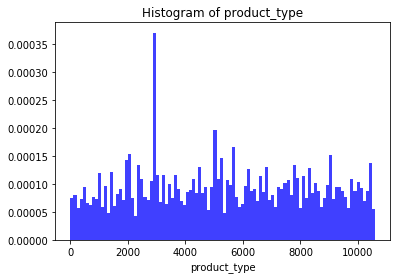

In [41]:
n, bins, patches = plt.hist(item_data.product_type, 100, density = 1, facecolor='blue', alpha=0.75)
plt.xlabel('product_type')
plt.title('Histogram of product_type')
plt.show();

In [215]:
print(train.app_code.value_counts()/len(train)).nlargest(5)

207    0.142200
386    0.129229
190    0.073402
127    0.045667
371    0.039321
3      0.037288
296    0.031367
129    0.029671
385    0.029359
32     0.025184
5      0.022735
249    0.021805
469    0.021556
283    0.019452
244    0.018387
44     0.018291
242    0.015829
145    0.015180
213    0.011856
463    0.010366
359    0.010071
231    0.009882
465    0.009225
151    0.009158
318    0.009154
202    0.008935
508    0.007651
163    0.006717
38     0.006363
37     0.006048
         ...   
437    0.000004
284    0.000004
52     0.000004
105    0.000004
429    0.000004
65     0.000004
149    0.000004
21     0.000004
332    0.000004
267    0.000004
418    0.000004
140    0.000004
109    0.000004
13     0.000004
269    0.000004
162    0.000004
301    0.000004
205    0.000004
459    0.000004
404    0.000004
417    0.000004
73     0.000004
72     0.000004
71     0.000004
376    0.000004
70     0.000004
401    0.000004
147    0.000004
66     0.000004
233    0.000004
Name: app_code, Length: 

AttributeError: 'NoneType' object has no attribute 'nlargest'

In [44]:
item_data.groupby('product_type').size().nlargest(5)

product_type
2874     4261
5622     1417
5036     1262
10412     990
7791      980
dtype: int64

In [45]:
train.groupby('app_code').size().nlargest(5)

app_code
207    33788
386    30706
190    17441
127    10851
371     9343
dtype: int64

In [78]:
train.groupby('is_click')['is_4G'].describe()

,count,mean,std,min,25%,50%,75%,max
is_click,,,,,,,,
0,226747.0,0.361676,0.480487,0.0,0.0,0.0,1.0,1.0
1,10862.0,0.353710,0.478143,0.0,0.0,0.0,1.0,1.0


In [74]:
train['app_code'].nunique()

490

In [75]:
test['app_code'].nunique()

373

In [76]:
item_data['product_type'].nunique()

7959

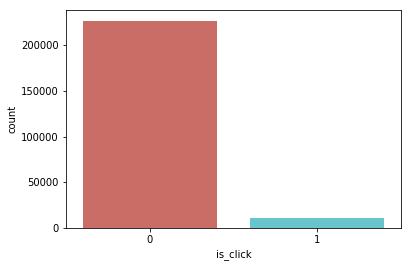

0    226747
1     10862
Name: is_click, dtype: int64

In [66]:
sns.countplot(x='is_click',data=train, palette='hls')
plt.show();
train['is_click'].value_counts()

In [80]:
train.impression_time.describe()

count                  237609
unique                  36461
top       2018-12-04 00:01:00
freq                       46
Name: impression_time, dtype: object

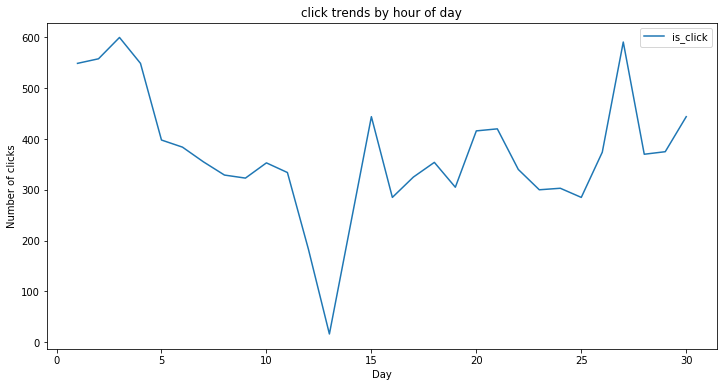

In [88]:
train.groupby('Day').agg({'is_click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day');

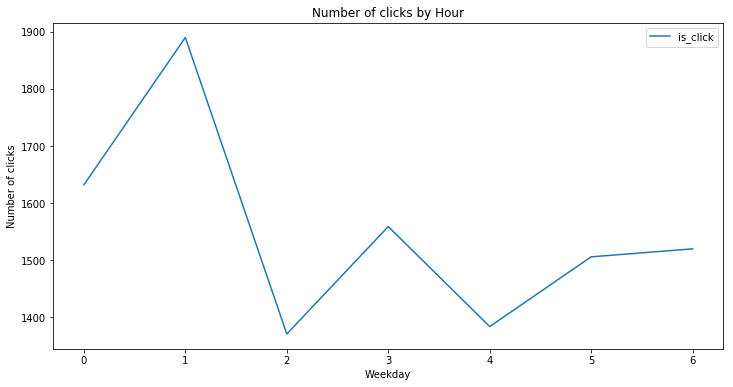

In [91]:
train.groupby('Weekday').agg({'is_click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by Hour');

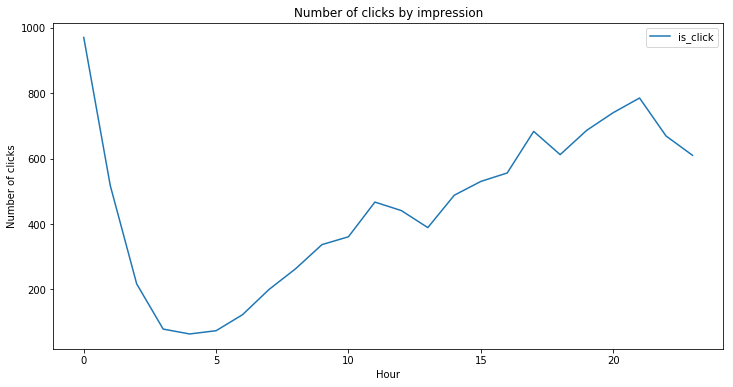

In [87]:
train.groupby('Hour').agg({'is_click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by Hour');

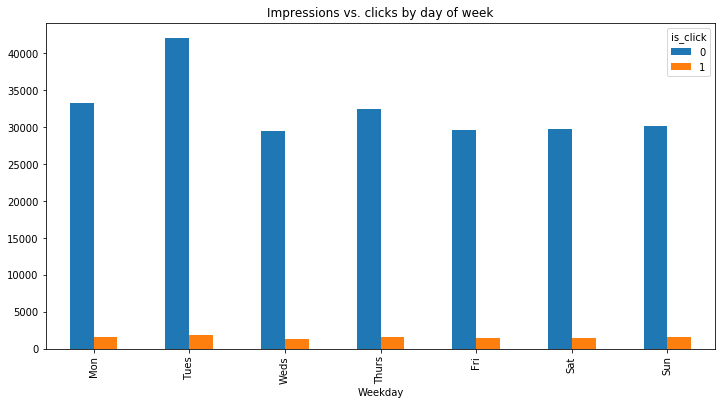

In [218]:
train.groupby(['Weekday','is_click']).size().unstack().reindex().plot(kind='bar', title="Day of the Week", figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('Impressions vs. clicks by day of week');

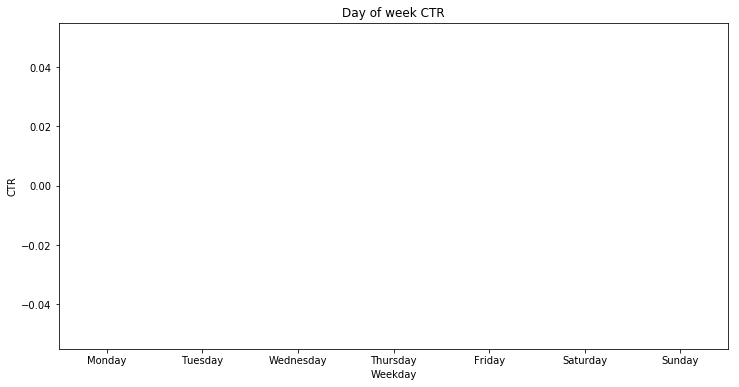

In [220]:
df_click = train[train['is_click'] == 1]
df_dayofweek = train[['Weekday','is_click']].groupby(['Weekday']).count().reset_index()
df_dayofweek = df_dayofweek.rename(columns={'is_click': 'impressions'})
df_dayofweek['is_click'] = df_click[['Weekday','is_click']].groupby(['Weekday']).count().reset_index()['is_click']
df_dayofweek['CTR'] = df_dayofweek['is_click']/df_dayofweek['impressions']*100
plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='Weekday', data=df_dayofweek, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Day of week CTR');

In [86]:
# Extract datetime variables using timestamp column
train['impression_time_Timestamp'] = pd.to_datetime(train['impression_time']) 
# Converting timestamp column into datatime object in order to extract new features
train['Month'] = train['impression_time_Timestamp'].dt.month 
# Creates a new column called Month
train['Day'] = train['impression_time_Timestamp'].dt.day     
# Creates a new column called Day
train['Hour'] = train['impression_time_Timestamp'].dt.hour   
# Creates a new column called Hour
train["Weekday"] = train['impression_time_Timestamp'].dt.dayofweek 
# Creates a new column called Weekday with sunday as 6 and monday as 0
# Other way to create a weekday column
#df['weekday'] = df['Timestamp'].apply(lambda x: x.weekday()) # Monday 0 .. sunday 6
# Dropping timestamp column to avoid redundancy
train = train.drop(['impression_time'], axis=1) # deleting timestamp

In [165]:
# Extract datetime variables using timestamp column
test['impression_time_Timestamp'] = pd.to_datetime(test['impression_time']) 
# Converting timestamp column into datatime object in order to extract new features
test['Month'] = test['impression_time_Timestamp'].dt.month 
# Creates a new column called Month
test['Day'] = test['impression_time_Timestamp'].dt.day     
# Creates a new column called Day
test['Hour'] = test['impression_time_Timestamp'].dt.hour   
# Creates a new column called Hour
test["Weekday"] = test['impression_time_Timestamp'].dt.dayofweek 
# Creates a new column called Weekday with sunday as 6 and monday as 0
# Other way to create a weekday column
#df['weekday'] = df['Timestamp'].apply(lambda x: x.weekday()) # Monday 0 .. sunday 6
# Dropping timestamp column to avoid redundancy
test = test.drop(['impression_time'], axis=1) # deleting timestamp

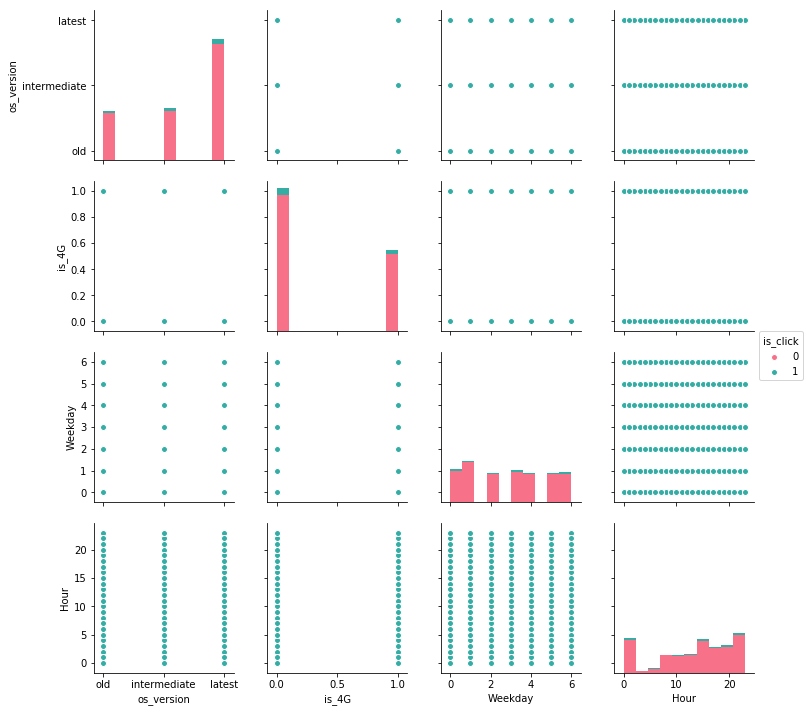

In [89]:
# Creating a pairplot with hue defined by Clicked on Ad column
sns.pairplot(train, hue = 'is_click', vars = ['os_version', 'is_4G', 'Weekday', 'Hour'], palette = 'husl')

In [313]:
test['is_click'] = '0'
df = train.append(test, ignore_index=True)
print(df.shape)

(328284, 11)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [166]:
test['is_click'] = 0

In [167]:
test.head(),test.shape,

(                      impression_id  user_id  app_code os_version  is_4G  \
 0  a9e7126a585a69a32bc7414e9d0c0ada    44754       127     latest      1   
 1  caac14a5bf2ba283db7708bb34855760    29656        44     latest      0   
 2  13f10ba306a19ce7bec2f3cae507b698    25234       296     latest      1   
 3  39c4b4dc0e9701b55a0a4f072008fb3f    22988       207     latest      1   
 4  bf5a572cca75f5fc67f4b14e58b11d70    35431       242     latest      1   
 
    ad_count  ad_pri  click_sum  ad_click impression_time_Timestamp  Month  \
 0   10851.0     1.0      577.0       1.0       2018-12-13 07:44:00     12   
 1    4346.0     1.0       27.0       0.0       2018-12-13 07:45:00     12   
 2    7453.0     1.0      574.0       1.0       2018-12-13 07:46:00     12   
 3   33788.0     1.0      482.0       1.0       2018-12-13 07:47:00     12   
 4    3761.0     1.0      371.0       1.0       2018-12-13 07:48:00     12   
 
    Day  Hour  Weekday  is_click  
 0   13     7        3         

In [170]:
test['ad_pri']=test['ad_pri'].astype(int)

In [171]:
test['ad_click']=test['ad_click'].astype(int)

In [33]:
test['ad_pri'].isnull().sum()

0

In [168]:
test['ad_pri'].fillna(0, inplace=True)

In [169]:
test['ad_click'].fillna(0, inplace=True)

In [172]:
test['ad_click'].isnull().sum()

0

In [173]:
test.shape,

((90675, 15),)

In [69]:
train1.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [95]:
usr_data = train.groupby("user_id").agg({"is_click": ["sum", "count"], "app_code": "nunique", 
                                            "Hour": ["mean", "std"], "Weekday":["mean", "std"]})
usr_data.columns = ["total_interest", "total_adclicks", "app_part", "hour_mean", "hour_std",
                   "dayofweek_mean", "dayofweek_std"]


usr_data['user_id']=usr_data.index
usr_data = usr_data.reset_index(drop=True)
usr_data.head()

,total_interest,total_adclicks,app_part,hour_mean,hour_std,dayofweek_mean,dayofweek_std,user_id
0,0,1,1,23.00,NaN,0.0,NaN,0
1,0,4,1,20.25,0.500000,1.0,0.816497,2
2,0,1,1,21.00,NaN,2.0,NaN,3
3,0,2,1,14.50,4.949747,1.0,0.000000,5
4,0,1,1,23.00,NaN,4.0,NaN,6


In [39]:
min(train['user_id']),max(train['user_id'])

(0, 92586)

In [96]:
usr_app_data = train.groupby(["user_id", "app_code"]).agg({"is_click": ["sum", "count"]})
usr_app_data.columns = ["usr_app_interest", "usr_app_adclicks"]
#usr_app_data['user_id']=usr_app_data.index
usr_app_data = usr_app_data.reset_index(drop=False)
usr_app_data.head()

,user_id,app_code,usr_app_interest,usr_app_adclicks
0,0,207,0,1
1,2,190,0,4
2,3,371,0,1
3,5,127,0,2
4,6,249,0,1


In [97]:
all_data = pd.merge(usr_data, usr_app_data, on=["user_id"], how="left")
all_data.head()

,total_interest,total_adclicks,app_part,hour_mean,hour_std,dayofweek_mean,dayofweek_std,user_id,app_code,usr_app_interest,usr_app_adclicks
0,0,1,1,23.00,NaN,0.0,NaN,0,207,0,1
1,0,4,1,20.25,0.500000,1.0,0.816497,2,190,0,4
2,0,1,1,21.00,NaN,2.0,NaN,3,371,0,1
3,0,2,1,14.50,4.949747,1.0,0.000000,5,127,0,2
4,0,1,1,23.00,NaN,4.0,NaN,6,249,0,1


In [59]:
all_data.head()

,total_interest,total_adclicks,app_part,hour_mean,hour_std,dayofweek_mean,dayofweek_std,user_id,app_code,usr_app_interest,usr_app_adclicks,interest_ratio,app_interest_ratio
0,0,1,1,23.00,0.000000,0.0,0.000000,0,207,0,1,0.0,0.0
1,0,4,1,20.25,0.500000,1.0,0.816497,2,190,0,4,0.0,0.0
2,0,1,1,21.00,0.000000,2.0,0.000000,3,371,0,1,0.0,0.0
3,0,2,1,14.50,4.949747,1.0,0.000000,5,127,0,2,0.0,0.0
4,0,1,1,23.00,0.000000,4.0,0.000000,6,249,0,1,0.0,0.0


In [98]:
all_data['dayofweek_std'].fillna(0, inplace=True)

In [99]:
all_data['hour_std'].fillna(0, inplace=True)

In [100]:
all_data["interest_ratio"] = all_data["total_interest"]/all_data["total_adclicks"]
all_data["app_interest_ratio"] = all_data["usr_app_interest"] / all_data["usr_app_adclicks"]

In [101]:
user_time = train.groupby(["user_id", "impression_time_Timestamp"]).size()
user_time.name = "user_time_counts"
user_time = user_time.reset_index()
user_time = user_time.groupby("user_id").agg({"user_time_counts": ["mean", "std", "max", "median", "skew"]})
user_time.columns = ["user_time_counts_mean", "user_time_counts_std", "user_time_counts_max",
                     "user_time_counts_median", "user_time_counts_skew"]
user_time = user_time.reset_index()
user_time.head()

,user_id,user_time_counts_mean,user_time_counts_std,user_time_counts_max,user_time_counts_median,user_time_counts_skew
0,0,1.0,NaN,1,1.0,NaN
1,2,1.0,0.0,1,1.0,0.0
2,3,1.0,NaN,1,1.0,NaN
3,5,1.0,0.0,1,1.0,NaN
4,6,1.0,NaN,1,1.0,NaN


In [174]:
user_time_test = test.groupby(["user_id", "impression_time_Timestamp"]).size()
user_time_test.name = "user_time_counts"
user_time_test = user_time_test.reset_index()
user_time_test = user_time_test.groupby("user_id").agg({"user_time_counts": ["mean", "std", "max", "median", "skew"]})
user_time_test.columns = ["user_time_counts_mean", "user_time_counts_std", "user_time_counts_max",
                     "user_time_counts_median", "user_time_counts_skew"]
user_time_test = user_time_test.reset_index()
user_time_test.head()

,user_id,user_time_counts_mean,user_time_counts_std,user_time_counts_max,user_time_counts_median,user_time_counts_skew
0,1,1.0,NaN,1,1.0,NaN
1,4,1.0,0.0,1,1.0,NaN
2,7,1.0,NaN,1,1.0,NaN
3,8,1.0,NaN,1,1.0,NaN
4,11,1.0,0.0,1,1.0,NaN


In [176]:
all_data.shape

(82788, 13)

In [186]:
test.head()

,impression_id,user_id,app_code_x,os_version,is_4G,ad_count,ad_pri,click_sum,ad_click,impression_time_Timestamp,...,app_part,hour_mean,hour_std,dayofweek_mean,dayofweek_std,app_code_y,usr_app_interest,usr_app_adclicks,interest_ratio,app_interest_ratio
0,a9e7126a585a69a32bc7414e9d0c0ada,44754,127,latest,1,10851.0,1,577.0,1,2018-12-13 07:44:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,caac14a5bf2ba283db7708bb34855760,29656,44,latest,0,4346.0,1,27.0,0,2018-12-13 07:45:00,...,1.0,6.333333,3.881580,2.000000,1.549193,44.0,0.0,6.0,0.0,0.0
2,13f10ba306a19ce7bec2f3cae507b698,25234,296,latest,1,7453.0,1,574.0,1,2018-12-13 07:46:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39c4b4dc0e9701b55a0a4f072008fb3f,22988,207,latest,1,33788.0,1,482.0,1,2018-12-13 07:47:00,...,1.0,14.142857,6.841749,1.714286,2.058663,207.0,0.0,7.0,0.0,0.0
4,bf5a572cca75f5fc67f4b14e58b11d70,35431,242,latest,1,3761.0,1,371.0,1,2018-12-13 07:48:00,...,1.0,12.200000,4.851478,2.650000,1.631112,242.0,4.0,20.0,0.2,0.2


In [103]:
train = pd.merge(train, all_data, on=["user_id"], how="left")

In [177]:
test = pd.merge(test, all_data, left_on="user_id", right_on="user_id", how="left")

In [179]:
test.shape

(112163, 27)

In [105]:
train = pd.merge(train, user_time, on=["user_id"], how="left")

In [202]:
test = pd.merge(test, user_time_test, left_on="user_id", right_on="user_id", how="left")

In [209]:
test.shape

(112163, 32)

In [203]:
Test_sample= test.drop_duplicates(subset=None, keep='first', inplace=True)

In [206]:
Test_sample

In [107]:
log_item_merge.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
0,2018-10-15 08:58:00,android,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0
1,2018-10-15 08:58:00,android,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0
2,2018-10-15 08:58:00,android,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0
3,2018-10-15 08:58:00,android,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0
4,2018-10-15 08:58:00,android,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0


In [154]:
train1.shape

(90675, 15)

In [153]:
test1.shape

NameError: name 'test1' is not defined

In [114]:
train['user_time_counts_std'].fillna(0, inplace=True)

In [115]:
train['user_time_counts_skew'].fillna(0, inplace=True)

In [116]:
test['user_time_counts_std'].fillna(0, inplace=True)

In [117]:
test['user_time_counts_skew'].fillna(0, inplace=True)

In [147]:
test=test.fillna(0)

In [148]:
 test.drop_duplicates(subset=None, keep='first', inplace=False)

impression_id                0
user_id                      0
app_code_x                   0
os_version                   0
is_4G                        0
ad_count                     0
ad_pri                       0
click_sum                    0
ad_click                     0
impression_time_Timestamp    0
Month                        0
Day                          0
Hour                         0
Weekday                      0
is_click                     0
total_interest               0
total_adclicks               0
app_part                     0
hour_mean                    0
hour_std                     0
dayofweek_mean               0
dayofweek_std                0
app_code_y                   0
usr_app_interest             0
usr_app_adclicks             0
interest_ratio               0
app_interest_ratio           0
user_time_counts_mean        0
user_time_counts_std         0
user_time_counts_max         0
user_time_counts_median      0
user_time_counts_skew        0
intermed

In [315]:
df[df['is_click']=='NA'].head()

,Day,Hour,Month,Weekday,app_code,impression_id,impression_time_Timestamp,is_4G,is_click,os_version,user_id


In [118]:
# One hot encoding for categorical variables
temp = pd.get_dummies(train['os_version'])
train = train.join(temp)
print(train.shape)

temp = pd.get_dummies(test['os_version'])
test = test.join(temp)
print(test.shape)


(309793, 35)
(112163, 35)


In [317]:
# Droping loan_id, dates & other categorical variables 
df1 = df.drop(['impression_id','impression_time_Timestamp','os_version','user_id'],axis=1)

In [199]:
sam=pd.read_csv('sample_submission - Copy.csv')

In [200]:
sam['is_click'].value_counts()

0    83499
1     7176
Name: is_click, dtype: int64

In [318]:
cols=['Day', 'Hour', 'Month', 'Weekday', 'app_code', 'is_4G','intermediate', 'is_click','latest', 'old']

In [198]:
test.head(25)

,impression_id,user_id,app_code_x,os_version,is_4G,ad_count,ad_pri,click_sum,ad_click,impression_time_Timestamp,...,app_part,hour_mean,hour_std,dayofweek_mean,dayofweek_std,app_code_y,usr_app_interest,usr_app_adclicks,interest_ratio,app_interest_ratio
0,a9e7126a585a69a32bc7414e9d0c0ada,44754,127,latest,1,10851.0,1,577.0,1,2018-12-13 07:44:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,caac14a5bf2ba283db7708bb34855760,29656,44,latest,0,4346.0,1,27.0,0,2018-12-13 07:45:00,...,1.0,6.333333,3.881580,2.000000,1.549193,44.0,0.0,6.0,0.000000,0.000000
2,13f10ba306a19ce7bec2f3cae507b698,25234,296,latest,1,7453.0,1,574.0,1,2018-12-13 07:46:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,39c4b4dc0e9701b55a0a4f072008fb3f,22988,207,latest,1,33788.0,1,482.0,1,2018-12-13 07:47:00,...,1.0,14.142857,6.841749,1.714286,2.058663,207.0,0.0,7.0,0.000000,0.000000
4,bf5a572cca75f5fc67f4b14e58b11d70,35431,242,latest,1,3761.0,1,371.0,1,2018-12-13 07:48:00,...,1.0,12.200000,4.851478,2.650000,1.631112,242.0,4.0,20.0,0.200000,0.200000
5,ca09514449e304fee91456fb0918667a,489,207,latest,0,33788.0,1,482.0,1,2018-12-13 07:48:00,...,1.0,8.800000,8.043631,4.200000,2.167948,207.0,0.0,5.0,0.000000,0.000000
6,b8b35cb0ae1719aa9f0ba7a9f3785687,44684,296,old,0,7453.0,1,574.0,1,2018-12-13 07:49:00,...,1.0,7.000000,0.000000,1.000000,0.000000,296.0,0.0,1.0,0.000000,0.000000
7,33502d1e85818b9b3414c8c006c34e07,76502,207,intermediate,0,33788.0,1,482.0,1,2018-12-13 07:50:00,...,1.0,7.000000,0.000000,1.000000,0.000000,207.0,0.0,1.0,0.000000,0.000000
8,5314e09fb680c56b58eb5a3b5b7bce0c,2128,260,intermediate,1,160.0,0,15.0,0,2018-12-13 07:50:00,...,3.0,9.038462,5.194120,3.019231,2.090974,151.0,0.0,11.0,0.057692,0.000000
9,5314e09fb680c56b58eb5a3b5b7bce0c,2128,260,intermediate,1,160.0,0,15.0,0,2018-12-13 07:50:00,...,3.0,9.038462,5.194120,3.019231,2.090974,260.0,1.0,22.0,0.057692,0.045455


In [319]:
train = df1.iloc[:237609,:][cols]
test = df1.iloc[237609:,:][cols]

In [128]:
train.shape,test.shape

((309793, 35), (112163, 35))

In [133]:

from sklearn.preprocessing import MinMaxScaler

# Fit on training data and scale test data
scaler = MinMaxScaler()
traindf = scaler.fit_transform(train.drop(columns = ['impression_id', 'user_id','os_version','impression_time_Timestamp'],axis=0))
testdf = scaler.transform(test.drop(columns = ['impression_id', 'user_id','os_version','impression_time_Timestamp'],axis=0))



In [134]:
traindf = pd.DataFrame(traindf, columns=['app_code_x','is_4G','is_click', 'ad_count', 'ad_pri', 'click_sum', 'ad_click','Month', 'Day', 'Hour', 'Weekday','total_interest', 'total_adclicks', 'app_part', 'hour_mean', 'hour_std','dayofweek_mean', 'dayofweek_std', 'app_code_y', 'usr_app_interest','usr_app_adclicks', 'interest_ratio', 'app_interest_ratio','user_time_counts_mean', 'user_time_counts_std', 'user_time_counts_max','user_time_counts_median', 'user_time_counts_skew', 'intermediate','latest', 'old'])
testdf = pd.DataFrame(testdf, columns=['app_code_x', 'is_4G','is_click', 'ad_count', 'ad_pri', 'click_sum', 'ad_click','Month', 'Day', 'Hour', 'Weekday','total_interest', 'total_adclicks', 'app_part', 'hour_mean', 'hour_std','dayofweek_mean', 'dayofweek_std', 'app_code_y', 'usr_app_interest','usr_app_adclicks', 'interest_ratio', 'app_interest_ratio','user_time_counts_mean', 'user_time_counts_std', 'user_time_counts_max','user_time_counts_median', 'user_time_counts_skew', 'intermediate','latest', 'old'])

In [135]:
numerical_features = traindf.select_dtypes(include=np.number)
categorical_features = traindf.select_dtypes(include=np.object)
print("numeric_features: ", numerical_features.shape, numerical_features.columns)
print("categorical_features: ", categorical_features.shape, categorical_features.columns)

numeric_features:  (309793, 31) Index(['app_code_x', 'is_4G', 'is_click', 'ad_count', 'ad_pri', 'click_sum',
       'ad_click', 'Month', 'Day', 'Hour', 'Weekday', 'total_interest',
       'total_adclicks', 'app_part', 'hour_mean', 'hour_std', 'dayofweek_mean',
       'dayofweek_std', 'app_code_y', 'usr_app_interest', 'usr_app_adclicks',
       'interest_ratio', 'app_interest_ratio', 'user_time_counts_mean',
       'user_time_counts_std', 'user_time_counts_max',
       'user_time_counts_median', 'user_time_counts_skew', 'intermediate',
       'latest', 'old'],
      dtype='object')
categorical_features:  (309793, 0) Index([], dtype='object')


In [136]:
X=traindf.drop(columns=['is_click'],axis=0)
y=traindf.is_click

In [137]:
def simple_model(alg):

    # splitting data into training and validation set
    xtrain, xtest, ytrain, ytest = train_test_split(X,y, random_state=42, test_size=0.2)
    model = alg
    model.fit(xtrain, ytrain) # training the model
#     prediction = model.predict_proba(xtest) # predicting on the validation set
#     prediction_int = prediction[:,1] >= 0.3 # if prediction is greater than or equal to 0.3 than 1 else 0
#     prediction_int = prediction_int.astype(np.int)

    print("f1_score:",f1_score(ytest, model.predict(xtest))) # calculating f1 score
    #print("AUC:",(ytest, model.predict(xtest))) # calculating f1 score
    print("Accuracy on train data:",model.score(xtrain,ytrain))
    print("Accuracy on test data:",model.score(xtest,ytest))

In [138]:
algs = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),ExtraTreesClassifier(),AdaBoostClassifier(),GradientBoostingClassifier()]
algs_lst = ['LR','DTC','RFC','ETC','ABC','GBC']
for alg,l in zip(algs,algs_lst):
    print(l)
    simple_model(alg=alg)

LR
f1_score: 0.4085603112840467
Accuracy on train data: 0.9612159752092126
Accuracy on test data: 0.9607482367371972
DTC
f1_score: 0.42457689477557026
Accuracy on train data: 0.992386032586328
Accuracy on test data: 0.9495150018560661
RFC
f1_score: 0.30603060306030605
Accuracy on train data: 0.9884842273457234
Accuracy on test data: 0.9502251488887813
ETC
f1_score: 0.31726739312657165
Accuracy on train data: 0.992386032586328
Accuracy on test data: 0.9474168401684985
ABC
f1_score: 0.35102266445550023
Accuracy on train data: 0.9620633165748042
Accuracy on test data: 0.9621039719814716
GBC
f1_score: 0.3688853247794707
Accuracy on train data: 0.96251926692867
Accuracy on test data: 0.9618941558127149


In [139]:
# Confusion Matrix (on AdaBoostClassifier)
from sklearn.metrics import confusion_matrix
xtrain, xtest, ytrain, ytest = train_test_split(X,y, random_state=42, test_size=0.2)
model = DecisionTreeClassifier()
model.fit(xtrain, ytrain)
ypred = model.predict(xtest)
confusion_matrix = confusion_matrix(ytest,ypred)
print(confusion_matrix)

[[57692  1542]
 [ 1562  1163]]


In [140]:
from sklearn.metrics import classification_report
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     59234
         1.0       0.43      0.43      0.43      2725

   micro avg       0.95      0.95      0.95     61959
   macro avg       0.70      0.70      0.70     61959
weighted avg       0.95      0.95      0.95     61959



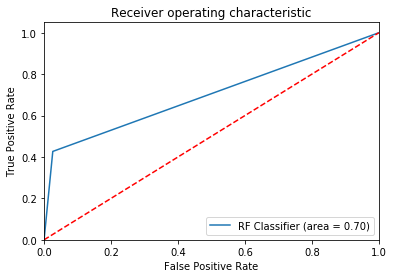

In [141]:
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(ytest, ypred)
fpr, tpr, thresholds = roc_curve(ytest, ypred)
plt.figure()
plt.plot(fpr, tpr, label='RF Classifier (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate'), plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

In [142]:
model = DecisionTreeClassifier(random_state=10)
model.fit(X, y)
ypred = model.predict(xtest)

In [143]:
train_pred=model.predict(train.drop(columns=['impression_id','impression_time_Timestamp','os_version','user_id','is_click'],axis=0))

In [149]:
test_pred=model.predict(test.drop(columns=['impression_id','impression_time_Timestamp','os_version','user_id','is_click'],axis=0))

In [190]:
final=test[['impression_id','is_click']]

In [192]:
final.shape

(112163, 2)

In [150]:
sample_submission1=sample_submission

In [194]:
final1=final

In [195]:
final=test[['impression_id','is_click']]
final1["is_click"]=test_pred.astype(int)

In [196]:
final1['is_click'].value_counts()

0    102082
1     10081
Name: is_click, dtype: int64

In [147]:
sample_submission1.to_csv("sample_submissiondt1.csv",index=False)

In [197]:
final1.to_csv("final1.csv",index=False)

In [449]:

# using gridsearch & cross validation, hypertune best parameters of Logistic Regression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
xtrain, xtest, ytrain, ytest = train_test_split(X,y, random_state=42, test_size=0.2)
print(xtrain.shape)
model = LogisticRegression()
grid = {'C':[0.001,0.01,0.1,1,5,10],
       'penalty':['l1','l2'],
        'class_weight':['balanced']}
# cv = KFold(n_splits = 10, shuffle=True, random_state = 7)
clf = GridSearchCV(model, grid, n_jobs=8, cv=None,scoring='f1_macro')
clf.fit(xtrain, ytrain)

(190087, 9)


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10], 'penalty': ['l1', 'l2'], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_macro', verbose=0)

In [450]:
clf.best_score_, clf.best_params_

(0.39331771463041715, {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'})

In [155]:
model = LogisticRegression(C= 0.1, class_weight= 'balanced', penalty= 'l1')
model.fit(xtrain, ytrain)
# ypred = model.predict(xtest)
prediction = model.predict_proba(xtest) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.55 # if prediction is greater than or equal to 0.3 than 1 else 0
ypred = prediction_int.astype(np.int)

print("f1_score:",f1_score(ytest, ypred)) # calculating f1 score
print("Accuracy on train data:",model.score(xtrain,ytrain))
print("Accuracy on test data:",model.score(xtest,ytest))

f1_score: 0.3946780962585945
Accuracy on train data: 0.8794233236763317
Accuracy on test data: 0.8779354088994334


In [156]:
pd.crosstab(ypred,ytest)

is_click,0.0,1.0
row_0,,
0,52970,515
1,6264,2210


In [157]:
print(classification_report(ytest,ypred))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94     59234
         1.0       0.26      0.81      0.39      2725

   micro avg       0.89      0.89      0.89     61959
   macro avg       0.63      0.85      0.67     61959
weighted avg       0.96      0.89      0.92     61959



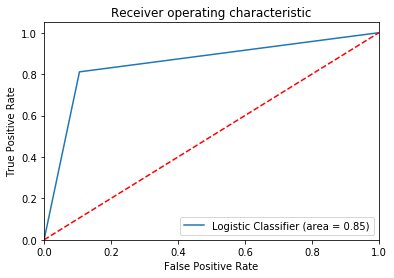

In [201]:
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(ytest, ypred)
fpr, tpr, thresholds = roc_curve(ytest, ypred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Classifier (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate'), plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

In [208]:
model = LogisticRegression(C= 0.1, class_weight='balanced' penalty= 'l1')
model.fit(X, y)
ypred = model.predict(xtest)

In [209]:
train_pred=model.predict(train.drop(columns=['is_click'],axis=0))

In [210]:
test_pred=model.predict(test.drop(columns=['is_click'],axis=0))

In [212]:
sample_submission1["is_click"]=test_pred.astype(int)

In [211]:
sample_submission1=sample_submission

In [213]:
sample_submission1['is_click'].value_counts()

1    90675
Name: is_click, dtype: int64

In [207]:
sample_submission1.to_csv("sample_submissionlg4.csv",index=False)

In [ ]:
#Grid Search and Random search for RF

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=42, test_size=0.2)
model = RandomForestClassifier()
grid = {'n_estimators': [10,20,30,50,100],
        #'learning_rate':[0.4,0.5,0.6,0.7],
        'max_features' : ['auto', 'sqrt'],
        'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
        'min_samples_split' : [2, 5, 10],
        'min_samples_leaf' : [1, 2, 4],
        'bootstrap' : [True, False],
        
       }
#         'learning_rate' : [0.5,0.52,0.54,0.56,0.58,0.6,0.62,0.64,0.66,0.68,0.7]}
# cv = KFold(n_splits = 10, shuffle=True, random_state = 7)
clf = GridSearchCV(model, grid, n_jobs=8, cv=None,scoring='f1_macro',verbose=2)
clf.fit(xtrain, ytrain)

Fitting 3 folds for each of 1980 candidates, totalling 5940 fits


[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:  2.3min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  5.3min


In [463]:

clf.best_score_, clf.best_params_

(0.48825683133663805, {'learning_rate': 0.4, 'n_estimators': 10})

In [464]:
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for m,s,p in zip(means,stds,params):
    print(m,s,p)

0.48825683133663805 8.941877859154185e-08 {'learning_rate': 0.4, 'n_estimators': 10}
0.48825683133663805 8.941877859154185e-08 {'learning_rate': 0.4, 'n_estimators': 20}
0.48825683133663805 8.941877859154185e-08 {'learning_rate': 0.4, 'n_estimators': 30}
0.48825683133663805 8.941877859154185e-08 {'learning_rate': 0.4, 'n_estimators': 50}
0.48825683133663805 8.941877859154185e-08 {'learning_rate': 0.4, 'n_estimators': 100}
0.48825683133663805 8.941877859154185e-08 {'learning_rate': 0.5, 'n_estimators': 10}
0.48825683133663805 8.941877859154185e-08 {'learning_rate': 0.5, 'n_estimators': 20}
0.48825683133663805 8.941877859154185e-08 {'learning_rate': 0.5, 'n_estimators': 30}
0.48825683133663805 8.941877859154185e-08 {'learning_rate': 0.5, 'n_estimators': 50}
0.48825683133663805 8.941877859154185e-08 {'learning_rate': 0.5, 'n_estimators': 100}
0.48825683133663805 8.941877859154185e-08 {'learning_rate': 0.6, 'n_estimators': 10}
0.48825683133663805 8.941877859154185e-08 {'learning_rate': 0.6

In [169]:
model = RandomForestClassifier()
model.fit(xtrain, ytrain)
# ypred = model.predict(xtest)
prediction = model.predict_proba(xtest) # predicting on the validation set
prediction_int = prediction[:,1] >= 0.56 # if prediction is greater than or equal to 0.3 than 1 else 0
ypred = prediction_int.astype(np.int)

print("f1_score:",f1_score(ytest, ypred)) # calculating f1 score
print("Accuracy on train data:",model.score(xtrain,ytrain))
print("Accuracy on test data:",model.score(xtest,ytest))

f1_score: 0.05567765567765567
Accuracy on train data: 0.965847217326803
Accuracy on test data: 0.9432683809603973


In [182]:
import xgboost as xgb
model_xg = xgb.XGBClassifier( learning_rate = 0.9,
           max_depth = 8,
          gamma = 1.1,
          alpha = 10,
          n_estimators = 200,objective = 'multi:softmax',num_class = 2,eval_metric ='merror',colsample_bytree = 0.7,n_jobs =-1)
model_xg.fit(xtrain,ytrain)
predict_xg = model_xg.predict(xtest)
pd.crosstab(ytest,predict_xg)
#predict_xg_t = model_xg.predict(train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


col_0,0.0,1.0
is_click,,
0.0,45339,45
1.0,2127,11


In [183]:
print (classification_report(ytest,predict_xg))

             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98     45384
        1.0       0.20      0.01      0.01      2138

avg / total       0.92      0.95      0.93     47522



In [185]:
# cat boost model
from catboost import CatBoostClassifier
model_cb = CatBoostClassifier(learning_rate = 0.01,iterations = 800,depth =7, eval_metric = 'F1').fit(xtrain,ytrain)
predict_cb = model_cb.predict(xtest)
predict_cb = predict_cb.flatten()
pd.crosstab(ytest,predict_cb)

ModuleNotFoundError: No module named 'catboost'

In [170]:

pd.crosstab(ypred,ytest)

is_click,0.0,1.0
row_0,,
0,44868,2062
1,516,76


In [171]:
from sklearn.metrics import classification_report
print(classification_report(ytest,ypred))

             precision    recall  f1-score   support

        0.0       0.96      0.99      0.97     45384
        1.0       0.13      0.04      0.06      2138

avg / total       0.92      0.95      0.93     47522



In [172]:
print(classification_report(ytest,ypred))

             precision    recall  f1-score   support

        0.0       0.96      0.99      0.97     45384
        1.0       0.13      0.04      0.06      2138

avg / total       0.92      0.95      0.93     47522



In [173]:
model = RandomForestClassifier()
model.fit(X, y)
ypred = model.predict(xtest)

In [174]:
train_pred=model.predict(train.drop(columns=['impression_id','impression_time_Timestamp','os_version','user_id','is_click'],axis=0))

In [175]:
test_pred=model.predict(test.drop(columns=['impression_id','impression_time_Timestamp','os_version','user_id','is_click'],axis=0))

In [177]:
sample_submission1["is_click"]=test_pred.astype(int)

In [176]:
sample_submission1=sample_submission

In [178]:
sample_submission1['is_click'].value_counts()

0    90675
Name: is_click, dtype: int64

In [112]:
sample_submission1.to_csv("sample_submissionDT1.csv",index=False)

In [ ]:
#Light GBM 

In [211]:
import lightgbm as lgb

In [212]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': { 'binary_logloss'},
    'num_leaves': 31, # defauly leaves(31) amount for each tree
    'learning_rate': 0.08,
    'feature_fraction': 0.7, # will select 70% features before training each tree
    'bagging_fraction': 0.3, #feature_fraction, but this will random select part of data
    'bagging_freq': 5, #  perform bagging at every 5 iteration
    'verbose': 0
}

In [213]:
#X_train = train.loc[:, train.columns != 'click']
#y_target = train.click.values
#create lightgbm dataset
msk = np.random.rand(len(xtrain)) < 0.8
lgb_train = lgb.Dataset(xtrain[msk], ytrain[msk])
lgb_eval = lgb.Dataset(xtrain[~msk], ytrain[~msk], reference=lgb_train)

In [214]:
print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=lgb_eval,
                early_stopping_rounds=500)

Start training...
[1]	valid_0's binary_logloss: 0.156002
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's binary_logloss: 0.146458
[3]	valid_0's binary_logloss: 0.139265
[4]	valid_0's binary_logloss: 0.133646
[5]	valid_0's binary_logloss: 0.129137
[6]	valid_0's binary_logloss: 0.12608
[7]	valid_0's binary_logloss: 0.122847
[8]	valid_0's binary_logloss: 0.12003
[9]	valid_0's binary_logloss: 0.117608
[10]	valid_0's binary_logloss: 0.115413
[11]	valid_0's binary_logloss: 0.113376
[12]	valid_0's binary_logloss: 0.11199
[13]	valid_0's binary_logloss: 0.110333
[14]	valid_0's binary_logloss: 0.108919
[15]	valid_0's binary_logloss: 0.107559
[16]	valid_0's binary_logloss: 0.106376
[17]	valid_0's binary_logloss: 0.105318
[18]	valid_0's binary_logloss: 0.104387
[19]	valid_0's binary_logloss: 0.103521
[20]	valid_0's binary_logloss: 0.102735
[21]	valid_0's binary_logloss: 0.102044
[22]	valid_0's binary_logloss: 0.101418
[23]	valid_0's binary_logloss: 0.100835
[24]	valid_

[197]	valid_0's binary_logloss: 0.0965628
[198]	valid_0's binary_logloss: 0.0965602
[199]	valid_0's binary_logloss: 0.0965989
[200]	valid_0's binary_logloss: 0.0966313
[201]	valid_0's binary_logloss: 0.0966393
[202]	valid_0's binary_logloss: 0.0966515
[203]	valid_0's binary_logloss: 0.0966131
[204]	valid_0's binary_logloss: 0.096568
[205]	valid_0's binary_logloss: 0.096614
[206]	valid_0's binary_logloss: 0.0965849
[207]	valid_0's binary_logloss: 0.0965895
[208]	valid_0's binary_logloss: 0.0965836
[209]	valid_0's binary_logloss: 0.250387
[210]	valid_0's binary_logloss: 0.0966031
[211]	valid_0's binary_logloss: 0.0966393
[212]	valid_0's binary_logloss: 0.0966161
[213]	valid_0's binary_logloss: 0.0966605
[214]	valid_0's binary_logloss: 0.0966294
[215]	valid_0's binary_logloss: 0.0966607
[216]	valid_0's binary_logloss: 0.0966021
[217]	valid_0's binary_logloss: 0.0966274
[218]	valid_0's binary_logloss: 0.109192
[219]	valid_0's binary_logloss: 0.0966841
[220]	valid_0's binary_logloss: 0.0967

[394]	valid_0's binary_logloss: 0.100294
[395]	valid_0's binary_logloss: 0.0999943
[396]	valid_0's binary_logloss: 0.1
[397]	valid_0's binary_logloss: 0.100006
[398]	valid_0's binary_logloss: 0.100014
[399]	valid_0's binary_logloss: 0.100028
[400]	valid_0's binary_logloss: 0.100028
[401]	valid_0's binary_logloss: 0.0999278
[402]	valid_0's binary_logloss: 0.0999473
[403]	valid_0's binary_logloss: 0.0999409
[404]	valid_0's binary_logloss: 0.0999381
[405]	valid_0's binary_logloss: 0.0999403
[406]	valid_0's binary_logloss: 0.0999629
[407]	valid_0's binary_logloss: 0.0999377
[408]	valid_0's binary_logloss: 0.0999182
[409]	valid_0's binary_logloss: 0.0999716
[410]	valid_0's binary_logloss: 0.0999383
[411]	valid_0's binary_logloss: 0.0999219
[412]	valid_0's binary_logloss: 0.0998674
[413]	valid_0's binary_logloss: 0.0998348
[414]	valid_0's binary_logloss: 0.0998186
[415]	valid_0's binary_logloss: 0.0998159
[416]	valid_0's binary_logloss: 0.10384
[417]	valid_0's binary_logloss: 0.09912
[418]	v

In [215]:
print(gbm.best_score)
print(gbm.best_iteration)

defaultdict(<class 'dict'>, {'valid_0': {'binary_logloss': 0.0946351905623844}})
72


In [216]:
y_pred_train = gbm.predict(xtrain)
score = roc_auc_score(ytrain, y_pred_train)
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.957


In [217]:
ypred = gbm.predict(xtest)
score = roc_auc_score(ytest, ypred)
print("Overall AUC: {:.3f}" .format(score))

Overall AUC: 0.948


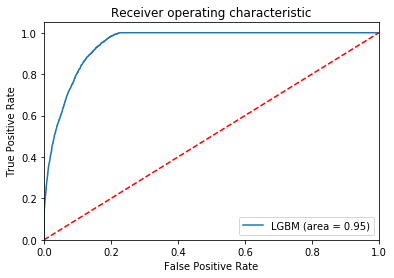

In [218]:
from sklearn.metrics import roc_auc_score, roc_curve

auc = roc_auc_score(ytest, ypred)
fpr, tpr, thresholds = roc_curve(ytest, ypred)
plt.figure()
plt.plot(fpr, tpr, label='LGBM (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate'), plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
plt.show()

In [219]:
train_pred=gbm.predict(traindf.drop(columns=['is_click'],axis=0))

In [220]:
sub_pred = gbm.predict(testdf.drop(columns=['is_click'],axis=0))

In [221]:
print(sub_pred)

[1.79798144e-04 1.81480422e-04 1.79798144e-04 ... 1.77460700e-04
 6.51170961e-01 8.16983779e-01]


In [222]:
sub_pred = np.clip(sub_pred, 0, 1)

In [223]:
sub_pred.min(), sub_pred.max()

(0.0001522387194129194, 0.9957381756032374)

In [321]:
sample_submission1=sample_submission
sample_submission1.to_csv('subm_lgbm_auc{:.8f}.csv'.format(score), index=False, float_format='%.8f')
sample_submission1['is_click']=sub_pred
sample_submission1['is_click'] = sample_submission1.is_click.map( lambda x: 1 if x > 0.5 else 0)

In [245]:
final=test[['impression_id','is_click']]

In [265]:
final1=test[['impression_id','is_click']]
final1.to_csv('subm_lgbm_auc{:.8f}.csv'.format(score), index=False, float_format='%.8f')
final1['is_click']=sub_pred
final1['is_click'] = final1.is_click.map( lambda x: 1 if x > 0.02 else 0)

In [266]:
final1.head()

,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0
1,caac14a5bf2ba283db7708bb34855760,0
2,13f10ba306a19ce7bec2f3cae507b698,0
3,39c4b4dc0e9701b55a0a4f072008fb3f,0
4,bf5a572cca75f5fc67f4b14e58b11d70,1


In [269]:
final1['is_click'].value_counts()

0    73990
1    16685
Name: is_click, dtype: int64

In [268]:
final1.drop_duplicates(subset ="impression_id",keep = 'first', inplace = True)

In [270]:
final1.to_csv("finallgbm.csv",index=False)

In [258]:
test.shape

(112163, 32)

In [ ]:
#Adaboost with logistic regression method

In [271]:
# Adaboost Classifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
#dtree = DecisionTreeClassifier(criterion='entropy',max_depth=2,random_state=42)

dtree = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=42, verbose=0,
            warm_start=False)
"""dtree=LogisticRegression(C= 0.2, class_weight= 'balanced', penalty= 'l1')"""

adabst_fit = AdaBoostClassifier(base_estimator= dtree,
        n_estimators=500,random_state = 42)

In [ ]:
adabst_fit.fit(xtrain, ytrain)

In [118]:

y_pred_train = dtree.predict(xtrain)

In [119]:
from sklearn import metrics
metrics.confusion_matrix(ytrain,y_pred_train)

array([[95184, 86179],
       [ 3825,  4899]], dtype=int64)

In [120]:

ypred = dtree.predict(xtest)

In [121]:
metrics.f1_score(ytest,ypred)

0.09603289791969037

In [66]:
print("f1_score:",f1_score(ytest, ypred)) # calculating f1 score
print("Accuracy on train data:",model.score(xtrain,ytrain))
print("Accuracy on test data:",model.score(xtest,ytest))

f1_score: 0.020725388601036267
Accuracy on train data: 0.9642847748662454
Accuracy on test data: 0.965426539287067


In [122]:
dtree.fit(X, y)

LogisticRegression(C=0.2, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [123]:
train_pred=dtree.predict(train.drop(columns=['impression_id','impression_time_Timestamp','os_version','user_id','is_click'],axis=0))

In [124]:
test_pred=dtree.predict(test.drop(columns=['impression_id','impression_time_Timestamp','os_version','user_id','is_click'],axis=0))

In [125]:
sample_submission1=sample_submission

In [126]:
sample_submission1["is_click"]=test_pred.astype(int)

In [127]:
sample_submission1['is_click'].value_counts()

0    52776
1    37899
Name: is_click, dtype: int64

In [128]:
sample_submission1.to_csv("sample_submissionLFg.csv",index=False)

In [74]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [75]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500]}


In [76]:

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 76.2min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [100, 144, 188, 233, 277, 322, 366, 411, 455, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [77]:
rf_random.best_params_

{'n_estimators': 500,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}